In [ ]:
#import utils, torch, time, os, pickle
import torch, time, os, pickle
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
#from dataloader import dataloader


from torch.utils.data import DataLoader
from torchvision import datasets, transforms

input_size = 28
batch_size = 64
transform = transforms.Compose([transforms.Resize((input_size, input_size)), transforms.ToTensor(), transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
data_loader = DataLoader(
            datasets.CIFAR10('data/cifar10', train=True, download=True, transform=transform),
            batch_size=batch_size, shuffle=True)


Extracting data/cifar10/cifar-10-python.tar.gz to data/cifar10


In [ ]:
class generator(nn.Module):
    def __init__(self, input_dim=100, output_dim=1, input_size=32):
        super(generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            #nn.BatchNorm1d(1024),
            #nn.ReLU(),
            nn.LeakyReLU(),
            nn.Linear(1024, 128 * (self.input_size // 4) * (self.input_size // 4)),
            #nn.BatchNorm1d(128 * (self.input_size // 4) * (self.input_size // 4)),
            #nn.ReLU(),
            nn.LeakyReLU(),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            #nn.ReLU(),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )
        initialize_weights(self)

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)

        return x

In [ ]:
class discriminator(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, input_size=32):
        super(discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            #nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid(),
        )
        initialize_weights(self)

    def forward(self, input):
        x = self.conv(input)
        x = x.view(-1, 128 * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)

        return x

In [ ]:
# Base GAN
class GAN(object):
    def __init__(self, args):
        # parameters
        self.epoch = args['epoch']
        self.sample_num = 100
        self.batch_size = args['batch_size']
        self.save_dir = args['save_dir']
        self.result_dir = args['result_dir']
        self.dataset = args['dataset']
        self.log_dir = args['log_dir']
        self.gpu_mode = args['gpu_mode']
        self.model_name = args['gan_type']
        self.input_size = args['input_size']
        self.z_dim = 62

        # load dataset
        self.data_loader = data_loader#dataloader(self.dataset, self.input_size, self.batch_size)
        data = self.data_loader.__iter__().__next__()[0]

        # networks init
        self.G = generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=args['lrG'], betas=(args['beta1'], args['beta2']))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=args['lrD'], betas=(args['beta1'], args['beta2']))

        if self.gpu_mode:
            self.G.cuda()
            self.D.cuda()
            self.BCE_loss = nn.BCELoss().cuda()
        else:
            self.BCE_loss = nn.BCELoss()

        print('----------       GAN  Type       -------------')
        print(args['gan_type'])
        print('---------- Networks architecture -------------')
        print_network(self.G)
        print_network(self.D)
        print('-----------------------------------------------')


        # fixed noise
        self.sample_z_ = torch.rand((self.batch_size, self.z_dim))
        if self.gpu_mode:
            self.sample_z_ = self.sample_z_.cuda()


    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []
        self.train_hist['per_epoch_time'] = []
        self.train_hist['total_time'] = []

        self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1), torch.zeros(self.batch_size, 1)
        if self.gpu_mode:
            self.y_real_, self.y_fake_ = self.y_real_.cuda(), self.y_fake_.cuda()

        self.D.train()
        print('training start!!')
        start_time = time.time()
        for epoch in range(self.epoch):
            self.G.train()
            epoch_start_time = time.time()
            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                z_ = torch.rand((self.batch_size, self.z_dim))
                if self.gpu_mode:
                    x_, z_ = x_.cuda(), z_.cuda()

                # update D network
                self.D_optimizer.zero_grad()

                D_real = self.D(x_)
                D_real_loss = self.BCE_loss(D_real, self.y_real_)

                G_ = self.G(z_)
                D_fake = self.D(G_)
                D_fake_loss = self.BCE_loss(D_fake, self.y_fake_)

                D_loss = D_real_loss + D_fake_loss
                self.train_hist['D_loss'].append(D_loss.item())

                D_loss.backward()
                self.D_optimizer.step()

                # update G network
                self.G_optimizer.zero_grad()

                G_ = self.G(z_)
                D_fake = self.D(G_)
                G_loss = self.BCE_loss(D_fake, self.y_real_)
                self.train_hist['G_loss'].append(G_loss.item())

                G_loss.backward()
                self.G_optimizer.step()

                if ((iter + 1) % 100) == 0:
                    print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f" %
                          ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size, D_loss.item(), G_loss.item()))

            self.train_hist['per_epoch_time'].append(time.time() - epoch_start_time)
            with torch.no_grad():
                self.visualize_results((epoch+1))

        self.train_hist['total_time'].append(time.time() - start_time)
        print("Avg one epoch time: %.2f, total %d epochs time: %.2f" % (np.mean(self.train_hist['per_epoch_time']),
              self.epoch, self.train_hist['total_time'][0]))
        print("Training finish!... save training results")

        self.save()
        generate_animation(self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name,
                                 self.epoch)
        loss_plot(self.train_hist, os.path.join(self.save_dir, self.dataset, self.model_name), self.model_name)

    def visualize_results(self, epoch, fix=True):
        self.G.eval()

        if not os.path.exists(self.result_dir + '/' + self.dataset + '/' + self.model_name):
            os.makedirs(self.result_dir + '/' + self.dataset + '/' + self.model_name)

        tot_num_samples = min(self.sample_num, self.batch_size)
        image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))

        if fix:
            """ fixed noise """
            samples = self.G(self.sample_z_)
        else:
            """ random noise """
            sample_z_ = torch.rand((self.batch_size, self.z_dim))
            if self.gpu_mode:
                sample_z_ = sample_z_.cuda()

            samples = self.G(sample_z_)

        if self.gpu_mode:
            samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        else:
            samples = samples.data.numpy().transpose(0, 2, 3, 1)

        samples = (samples + 1) / 2
        save_images(samples[:image_frame_dim * image_frame_dim, :, :, :], [image_frame_dim, image_frame_dim],
                          self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name + '_epoch%03d' % epoch + '.png')

    def save(self):
        save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)

        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        torch.save(self.G.state_dict(), os.path.join(save_dir, self.model_name + '_G.pkl'))
        torch.save(self.D.state_dict(), os.path.join(save_dir, self.model_name + '_D.pkl'))

        with open(os.path.join(save_dir, self.model_name + '_history.pkl'), 'wb') as f:
            pickle.dump(self.train_hist, f)

    def load(self):
        save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)

        self.G.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_G.pkl')))
        self.D.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_D.pkl')))

In [ ]:
# Utils

import os, gzip, torch
import torch.nn as nn
import numpy as np
import scipy.misc
import imageio
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

def load_mnist(dataset):
    data_dir = os.path.join("./data", dataset)

    def extract_data(filename, num_data, head_size, data_size):
        with gzip.open(filename) as bytestream:
            bytestream.read(head_size)
            buf = bytestream.read(data_size * num_data)
            data = np.frombuffer(buf, dtype=np.uint8).astype(np.float)
        return data

    data = extract_data(data_dir + '/train-images-idx3-ubyte.gz', 60000, 16, 28 * 28)
    trX = data.reshape((60000, 28, 28, 1))

    data = extract_data(data_dir + '/train-labels-idx1-ubyte.gz', 60000, 8, 1)
    trY = data.reshape((60000))

    data = extract_data(data_dir + '/t10k-images-idx3-ubyte.gz', 10000, 16, 28 * 28)
    teX = data.reshape((10000, 28, 28, 1))

    data = extract_data(data_dir + '/t10k-labels-idx1-ubyte.gz', 10000, 8, 1)
    teY = data.reshape((10000))

    trY = np.asarray(trY).astype(np.int)
    teY = np.asarray(teY)

    X = np.concatenate((trX, teX), axis=0)
    y = np.concatenate((trY, teY), axis=0).astype(np.int)

    seed = 547
    np.random.seed(seed)
    np.random.shuffle(X)
    np.random.seed(seed)
    np.random.shuffle(y)

    y_vec = np.zeros((len(y), 10), dtype=np.float)
    for i, label in enumerate(y):
        y_vec[i, y[i]] = 1

    X = X.transpose(0, 3, 1, 2) / 255.
    # y_vec = y_vec.transpose(0, 3, 1, 2)

    X = torch.from_numpy(X).type(torch.FloatTensor)
    y_vec = torch.from_numpy(y_vec).type(torch.FloatTensor)
    return X, y_vec

def load_celebA(dir, transform, batch_size, shuffle):
    # transform = transforms.Compose([
    #     transforms.CenterCrop(160),
    #     transform.Scale(64)
    #     transforms.ToTensor(),
    #     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    # ])

    # data_dir = 'data/celebA'  # this path depends on your computer
    dset = datasets.ImageFolder(dir, transform)
    data_loader = torch.utils.data.DataLoader(dset, batch_size, shuffle)

    return data_loader


def print_network(net):
    num_params = 0
    for param in net.parameters():
        num_params += param.numel()
    print(net)
    print('Total number of parameters: %d' % num_params)

def save_images(images, size, image_path):
    return imsave(images, size, image_path)

def imsave(images, size, path):
    image = np.squeeze(merge(images, size))
    #image_uint8 = image.astype(np.uint8)
    #return scipy.misc.imsave(path, image)
    #return imageio.imwrite(path, image_uint8)
    return imageio.imwrite(path, image)

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    if (images.shape[3] in (3,4)):
        c = images.shape[3]
        img = np.zeros((h * size[0], w * size[1], c))
        for idx, image in enumerate(images):
            i = idx % size[1]
            j = idx // size[1]
            img[j * h:j * h + h, i * w:i * w + w, :] = image
        return img
    elif images.shape[3]==1:
        img = np.zeros((h * size[0], w * size[1]))
        for idx, image in enumerate(images):
            i = idx % size[1]
            j = idx // size[1]
            img[j * h:j * h + h, i * w:i * w + w] = image[:,:,0]
        return img
    else:
        raise ValueError('in merge(images,size) images parameter ''must have dimensions: HxW or HxWx3 or HxWx4')

def generate_animation(path, num):
    images = []
    for e in range(num):
        img_name = path + '_epoch%03d' % (e+1) + '.png'
        images.append(imageio.imread(img_name))
    imageio.mimsave(path + '_generate_animation.gif', images, fps=5)

def loss_plot(hist, path = 'Train_hist.png', model_name = ''):
    x = range(len(hist['D_loss']))

    y1 = hist['D_loss']
    y2 = hist['G_loss']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    path = os.path.join(path, model_name + '_loss.png')

    plt.savefig(path)

    plt.close()

def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [ ]:
args = {'gan_type':'GAN','dataset':'cifar10','split':'','epoch':50,'batch_size':64,'input_size':28,'save_dir':'models','result_dir':'results','log_dir':'logs',
        'lrG':0.00001,'lrD':0.00001,'beta1':0.5,'beta2':0.999,'gpu_mode':False,'benchmark_mode':True}

#args['gan_type'] = 'GAN'
gan = GAN(args)
gan.train()
gan.visualize_results(args['epoch'])

----------       GAN  Type       -------------
GAN
---------- Networks architecture -------------
generator(
  (fc): Sequential(
    (0): Linear(in_features=62, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=1024, out_features=6272, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Tanh()
  )
)
Total number of parameters: 6627651
discriminator(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affin

Epoch: [ 2] [ 100/ 781] D_loss: 0.09888861, G_loss: 3.29447031
Epoch: [ 2] [ 200/ 781] D_loss: 0.05915105, G_loss: 3.58572865
Epoch: [ 2] [ 300/ 781] D_loss: 0.14923078, G_loss: 3.50713086
Epoch: [ 2] [ 400/ 781] D_loss: 0.07037097, G_loss: 3.59793925
Epoch: [ 2] [ 500/ 781] D_loss: 0.14904857, G_loss: 3.55966020
Epoch: [ 2] [ 600/ 781] D_loss: 0.05294215, G_loss: 3.88397789
Epoch: [ 2] [ 700/ 781] D_loss: 0.12140607, G_loss: 3.45163536


Epoch: [ 3] [ 100/ 781] D_loss: 0.14800991, G_loss: 3.52935934
Epoch: [ 3] [ 200/ 781] D_loss: 0.06309767, G_loss: 3.75356436
Epoch: [ 3] [ 300/ 781] D_loss: 0.14145380, G_loss: 3.46389937
Epoch: [ 3] [ 400/ 781] D_loss: 0.06968887, G_loss: 3.81612754
Epoch: [ 3] [ 500/ 781] D_loss: 0.10264862, G_loss: 3.71340299
Epoch: [ 3] [ 600/ 781] D_loss: 0.14716062, G_loss: 3.59502220
Epoch: [ 3] [ 700/ 781] D_loss: 0.07418178, G_loss: 4.10275030


Epoch: [ 4] [ 100/ 781] D_loss: 0.03756854, G_loss: 4.35766077
Epoch: [ 4] [ 200/ 781] D_loss: 0.06758115, G_loss: 4.02216291
Epoch: [ 4] [ 300/ 781] D_loss: 0.05626621, G_loss: 4.44573784
Epoch: [ 4] [ 400/ 781] D_loss: 0.04015372, G_loss: 4.01570129
Epoch: [ 4] [ 500/ 781] D_loss: 0.03474955, G_loss: 4.46667576
Epoch: [ 4] [ 600/ 781] D_loss: 0.05259901, G_loss: 4.32585907
Epoch: [ 4] [ 700/ 781] D_loss: 0.04597669, G_loss: 4.58153105


Epoch: [ 5] [ 100/ 781] D_loss: 0.02258090, G_loss: 4.64653587
Epoch: [ 5] [ 200/ 781] D_loss: 0.01894274, G_loss: 4.71026373
Epoch: [ 5] [ 300/ 781] D_loss: 0.03622643, G_loss: 4.64908886
Epoch: [ 5] [ 400/ 781] D_loss: 0.02951246, G_loss: 4.72208309
Epoch: [ 5] [ 500/ 781] D_loss: 0.03436123, G_loss: 4.54247141
Epoch: [ 5] [ 600/ 781] D_loss: 0.02813469, G_loss: 4.30240393
Epoch: [ 5] [ 700/ 781] D_loss: 0.07992112, G_loss: 3.97571015


Epoch: [ 6] [ 100/ 781] D_loss: 0.02352901, G_loss: 4.77312946
Epoch: [ 6] [ 200/ 781] D_loss: 0.01453529, G_loss: 4.95974112
Epoch: [ 6] [ 300/ 781] D_loss: 0.06110627, G_loss: 4.60973263
Epoch: [ 6] [ 400/ 781] D_loss: 0.03566719, G_loss: 4.84809732
Epoch: [ 6] [ 500/ 781] D_loss: 0.09717868, G_loss: 4.52104855
Epoch: [ 6] [ 600/ 781] D_loss: 0.00825536, G_loss: 5.22203541
Epoch: [ 6] [ 700/ 781] D_loss: 0.01190987, G_loss: 5.59191513


Epoch: [ 7] [ 100/ 781] D_loss: 0.02195071, G_loss: 4.80296612
Epoch: [ 7] [ 200/ 781] D_loss: 0.05184807, G_loss: 4.84111309
Epoch: [ 7] [ 300/ 781] D_loss: 0.04987978, G_loss: 4.26762009
Epoch: [ 7] [ 400/ 781] D_loss: 0.03585878, G_loss: 4.81715679
Epoch: [ 7] [ 500/ 781] D_loss: 0.01478882, G_loss: 5.30111980
Epoch: [ 7] [ 600/ 781] D_loss: 0.04834092, G_loss: 4.59460640
Epoch: [ 7] [ 700/ 781] D_loss: 0.00972046, G_loss: 5.55572414


Epoch: [ 8] [ 100/ 781] D_loss: 0.02169178, G_loss: 5.21721458
Epoch: [ 8] [ 200/ 781] D_loss: 0.03994586, G_loss: 5.02168560
Epoch: [ 8] [ 300/ 781] D_loss: 0.02247431, G_loss: 4.95787859
Epoch: [ 8] [ 400/ 781] D_loss: 0.02449566, G_loss: 5.12071896
Epoch: [ 8] [ 500/ 781] D_loss: 0.03030892, G_loss: 5.58666134
Epoch: [ 8] [ 600/ 781] D_loss: 0.01630323, G_loss: 5.27068233
Epoch: [ 8] [ 700/ 781] D_loss: 0.05388001, G_loss: 5.15629578


Epoch: [ 9] [ 100/ 781] D_loss: 0.01703552, G_loss: 5.37187576
Epoch: [ 9] [ 200/ 781] D_loss: 0.02905816, G_loss: 5.45289326
Epoch: [ 9] [ 300/ 781] D_loss: 0.03323359, G_loss: 5.70389605
Epoch: [ 9] [ 400/ 781] D_loss: 0.01735361, G_loss: 5.35901165
Epoch: [ 9] [ 500/ 781] D_loss: 0.01868881, G_loss: 5.08061838
Epoch: [ 9] [ 600/ 781] D_loss: 0.00553666, G_loss: 5.86271811
Epoch: [ 9] [ 700/ 781] D_loss: 0.01004782, G_loss: 5.59611845


Epoch: [10] [ 100/ 781] D_loss: 0.02290556, G_loss: 6.31837463
Epoch: [10] [ 200/ 781] D_loss: 0.01301503, G_loss: 5.79769945
Epoch: [10] [ 300/ 781] D_loss: 0.03758461, G_loss: 4.49433088
Epoch: [10] [ 400/ 781] D_loss: 0.02660862, G_loss: 4.73926020
Epoch: [10] [ 500/ 781] D_loss: 0.07152227, G_loss: 4.59674072
Epoch: [10] [ 600/ 781] D_loss: 0.08287992, G_loss: 4.74051046
Epoch: [10] [ 700/ 781] D_loss: 0.28302699, G_loss: 3.71899581


Epoch: [11] [ 100/ 781] D_loss: 0.13108207, G_loss: 3.84627581
Epoch: [11] [ 200/ 781] D_loss: 0.17106494, G_loss: 3.97172976
Epoch: [11] [ 300/ 781] D_loss: 0.07917327, G_loss: 4.29705667
Epoch: [11] [ 400/ 781] D_loss: 0.08989991, G_loss: 4.18114758
Epoch: [11] [ 500/ 781] D_loss: 0.10962138, G_loss: 4.32196045
Epoch: [11] [ 600/ 781] D_loss: 0.07893156, G_loss: 4.54860783
Epoch: [11] [ 700/ 781] D_loss: 0.06344410, G_loss: 3.86574841


Epoch: [12] [ 100/ 781] D_loss: 0.13625722, G_loss: 3.91015673
Epoch: [12] [ 200/ 781] D_loss: 0.07420835, G_loss: 4.29876661
Epoch: [12] [ 300/ 781] D_loss: 0.04285249, G_loss: 4.87803268
Epoch: [12] [ 400/ 781] D_loss: 0.02947167, G_loss: 4.72437429
Epoch: [12] [ 500/ 781] D_loss: 0.04164134, G_loss: 4.69049835
Epoch: [12] [ 600/ 781] D_loss: 0.06939575, G_loss: 4.70224380
Epoch: [12] [ 700/ 781] D_loss: 0.02338755, G_loss: 4.62690830


Epoch: [13] [ 100/ 781] D_loss: 0.03277389, G_loss: 4.75241661
Epoch: [13] [ 200/ 781] D_loss: 0.08396029, G_loss: 3.87454557
Epoch: [13] [ 300/ 781] D_loss: 0.14044920, G_loss: 4.35915041
Epoch: [13] [ 400/ 781] D_loss: 0.07064013, G_loss: 4.36010790
Epoch: [13] [ 500/ 781] D_loss: 0.02645145, G_loss: 5.26228619
Epoch: [13] [ 600/ 781] D_loss: 0.12306920, G_loss: 4.70769119
Epoch: [13] [ 700/ 781] D_loss: 0.07335149, G_loss: 4.64086914


Epoch: [14] [ 100/ 781] D_loss: 0.04892670, G_loss: 4.32555246
Epoch: [14] [ 200/ 781] D_loss: 0.04740625, G_loss: 4.86748314
Epoch: [14] [ 300/ 781] D_loss: 0.05867393, G_loss: 4.73882294
Epoch: [14] [ 400/ 781] D_loss: 0.01544553, G_loss: 5.15985203
Epoch: [14] [ 500/ 781] D_loss: 0.13853660, G_loss: 3.75823975
Epoch: [14] [ 600/ 781] D_loss: 0.02001188, G_loss: 5.42766476
Epoch: [14] [ 700/ 781] D_loss: 0.04197240, G_loss: 6.04505062


Epoch: [15] [ 100/ 781] D_loss: 0.08456917, G_loss: 3.99109364
Epoch: [15] [ 200/ 781] D_loss: 0.14738545, G_loss: 3.65803623
Epoch: [15] [ 300/ 781] D_loss: 0.07013856, G_loss: 4.58090162
Epoch: [15] [ 400/ 781] D_loss: 0.03220647, G_loss: 4.84406471
Epoch: [15] [ 500/ 781] D_loss: 0.09839308, G_loss: 4.16294765
Epoch: [15] [ 600/ 781] D_loss: 0.16087461, G_loss: 4.17852688
Epoch: [15] [ 700/ 781] D_loss: 0.10965353, G_loss: 4.99650097


Epoch: [16] [ 100/ 781] D_loss: 0.07638901, G_loss: 4.44710779
Epoch: [16] [ 200/ 781] D_loss: 0.16270800, G_loss: 3.69284081
Epoch: [16] [ 300/ 781] D_loss: 0.03580263, G_loss: 4.73565006
Epoch: [16] [ 400/ 781] D_loss: 0.01987774, G_loss: 4.72105217
Epoch: [16] [ 500/ 781] D_loss: 0.06068435, G_loss: 4.41939163
Epoch: [16] [ 600/ 781] D_loss: 0.12399031, G_loss: 4.29257727
Epoch: [16] [ 700/ 781] D_loss: 0.02167831, G_loss: 4.75372887


Epoch: [17] [ 100/ 781] D_loss: 0.02618657, G_loss: 5.24114084
Epoch: [17] [ 200/ 781] D_loss: 0.03306703, G_loss: 5.19142962
Epoch: [17] [ 300/ 781] D_loss: 0.03893007, G_loss: 4.63880110
Epoch: [17] [ 400/ 781] D_loss: 0.05214900, G_loss: 4.50160170
Epoch: [17] [ 500/ 781] D_loss: 0.00911429, G_loss: 4.92775393
Epoch: [17] [ 600/ 781] D_loss: 0.02979033, G_loss: 4.81913996
Epoch: [17] [ 700/ 781] D_loss: 0.01646323, G_loss: 4.85288715


Epoch: [18] [ 100/ 781] D_loss: 0.02644314, G_loss: 5.41530752
Epoch: [18] [ 200/ 781] D_loss: 0.00798295, G_loss: 5.55812979
Epoch: [18] [ 300/ 781] D_loss: 0.03395355, G_loss: 5.31406832
Epoch: [18] [ 400/ 781] D_loss: 0.02122536, G_loss: 5.14895248
Epoch: [18] [ 500/ 781] D_loss: 0.01901094, G_loss: 5.85375881
Epoch: [18] [ 600/ 781] D_loss: 0.03086087, G_loss: 4.56560612
Epoch: [18] [ 700/ 781] D_loss: 0.05497575, G_loss: 6.39443111


Epoch: [19] [ 100/ 781] D_loss: 0.09024329, G_loss: 4.72916985
Epoch: [19] [ 200/ 781] D_loss: 0.13667610, G_loss: 4.53719473
Epoch: [19] [ 300/ 781] D_loss: 0.05107731, G_loss: 4.56970882
Epoch: [19] [ 400/ 781] D_loss: 0.27928373, G_loss: 3.90105629
Epoch: [19] [ 500/ 781] D_loss: 0.09406734, G_loss: 4.42263985
Epoch: [19] [ 600/ 781] D_loss: 0.05626174, G_loss: 4.16254139
Epoch: [19] [ 700/ 781] D_loss: 0.35383058, G_loss: 3.69467068


Epoch: [20] [ 100/ 781] D_loss: 0.01178448, G_loss: 5.32220078
Epoch: [20] [ 200/ 781] D_loss: 0.03938698, G_loss: 5.10105324
Epoch: [20] [ 300/ 781] D_loss: 0.14531763, G_loss: 4.95032930
Epoch: [20] [ 400/ 781] D_loss: 0.04976616, G_loss: 5.16508722
Epoch: [20] [ 500/ 781] D_loss: 0.11558728, G_loss: 4.45955801
Epoch: [20] [ 600/ 781] D_loss: 0.19586214, G_loss: 5.20178747
Epoch: [20] [ 700/ 781] D_loss: 0.35250604, G_loss: 3.60446262


Epoch: [21] [ 100/ 781] D_loss: 0.11198515, G_loss: 4.01772499
Epoch: [21] [ 200/ 781] D_loss: 0.12752776, G_loss: 4.18368864
Epoch: [21] [ 300/ 781] D_loss: 0.17794263, G_loss: 4.29252005
Epoch: [21] [ 400/ 781] D_loss: 0.11606155, G_loss: 4.24139690
Epoch: [21] [ 500/ 781] D_loss: 0.08444035, G_loss: 4.39071989
Epoch: [21] [ 600/ 781] D_loss: 0.02533324, G_loss: 4.86306429
Epoch: [21] [ 700/ 781] D_loss: 0.04449505, G_loss: 4.60778141


Epoch: [22] [ 100/ 781] D_loss: 0.03527277, G_loss: 4.78117323
Epoch: [22] [ 200/ 781] D_loss: 0.08724602, G_loss: 4.83534336
Epoch: [22] [ 300/ 781] D_loss: 0.02747184, G_loss: 4.81527567
Epoch: [22] [ 400/ 781] D_loss: 0.11442944, G_loss: 5.06177187
Epoch: [22] [ 500/ 781] D_loss: 0.05222178, G_loss: 4.54978466
Epoch: [22] [ 600/ 781] D_loss: 0.03588840, G_loss: 5.03164291
Epoch: [22] [ 700/ 781] D_loss: 0.04430665, G_loss: 5.21220016


Epoch: [23] [ 100/ 781] D_loss: 0.02572139, G_loss: 4.56213856
Epoch: [23] [ 200/ 781] D_loss: 0.02462238, G_loss: 4.87366533
Epoch: [23] [ 300/ 781] D_loss: 0.07768413, G_loss: 4.42929411
Epoch: [23] [ 400/ 781] D_loss: 0.09047318, G_loss: 4.06763077
Epoch: [23] [ 500/ 781] D_loss: 0.24583465, G_loss: 3.69442964
Epoch: [23] [ 600/ 781] D_loss: 0.13421820, G_loss: 3.99746037
Epoch: [23] [ 700/ 781] D_loss: 0.15190119, G_loss: 3.97821164


Epoch: [24] [ 100/ 781] D_loss: 0.04165646, G_loss: 4.59529352
Epoch: [24] [ 200/ 781] D_loss: 0.09890996, G_loss: 4.33163071
Epoch: [24] [ 300/ 781] D_loss: 0.02622855, G_loss: 5.66376066
Epoch: [24] [ 400/ 781] D_loss: 0.06416409, G_loss: 4.56944132
Epoch: [24] [ 500/ 781] D_loss: 0.11305611, G_loss: 4.51645184
Epoch: [24] [ 600/ 781] D_loss: 0.08377735, G_loss: 4.73794651
Epoch: [24] [ 700/ 781] D_loss: 0.11684511, G_loss: 4.59494591


Epoch: [25] [ 100/ 781] D_loss: 0.15807132, G_loss: 4.57194090
Epoch: [25] [ 200/ 781] D_loss: 0.05715282, G_loss: 4.27714348
Epoch: [25] [ 300/ 781] D_loss: 0.03957679, G_loss: 4.64738035
Epoch: [25] [ 400/ 781] D_loss: 0.01675270, G_loss: 5.00071430
Epoch: [25] [ 500/ 781] D_loss: 0.02140959, G_loss: 5.51533747
Epoch: [25] [ 600/ 781] D_loss: 0.03522069, G_loss: 5.31092739
Epoch: [25] [ 700/ 781] D_loss: 0.20355457, G_loss: 3.91478586


Epoch: [26] [ 100/ 781] D_loss: 0.18641846, G_loss: 4.93837166
Epoch: [26] [ 200/ 781] D_loss: 0.11733190, G_loss: 4.38622713
Epoch: [26] [ 300/ 781] D_loss: 0.07082351, G_loss: 4.56977749
Epoch: [26] [ 400/ 781] D_loss: 0.04822832, G_loss: 4.35079765
Epoch: [26] [ 500/ 781] D_loss: 0.03344291, G_loss: 4.71495056
Epoch: [26] [ 600/ 781] D_loss: 0.11899614, G_loss: 4.34958124
Epoch: [26] [ 700/ 781] D_loss: 0.13814825, G_loss: 4.15698481


Epoch: [27] [ 100/ 781] D_loss: 0.18028787, G_loss: 4.34063721
Epoch: [27] [ 200/ 781] D_loss: 0.13137710, G_loss: 4.76007795
Epoch: [27] [ 300/ 781] D_loss: 0.06402673, G_loss: 4.76351595
Epoch: [27] [ 400/ 781] D_loss: 0.04399772, G_loss: 5.42007971
Epoch: [27] [ 500/ 781] D_loss: 0.05422340, G_loss: 4.84385014
Epoch: [27] [ 600/ 781] D_loss: 0.04579676, G_loss: 4.93035460
Epoch: [27] [ 700/ 781] D_loss: 0.13567364, G_loss: 4.50202131


Epoch: [28] [ 100/ 781] D_loss: 0.06312005, G_loss: 4.82982445
Epoch: [28] [ 200/ 781] D_loss: 0.06153876, G_loss: 4.86897755
Epoch: [28] [ 300/ 781] D_loss: 0.06214386, G_loss: 4.90093756
Epoch: [28] [ 400/ 781] D_loss: 0.07157630, G_loss: 5.35079193
Epoch: [28] [ 500/ 781] D_loss: 0.03767427, G_loss: 4.49507761
Epoch: [28] [ 600/ 781] D_loss: 0.09630635, G_loss: 4.90422630
Epoch: [28] [ 700/ 781] D_loss: 0.09447344, G_loss: 4.62279510


Epoch: [29] [ 100/ 781] D_loss: 0.10573804, G_loss: 4.86048460
Epoch: [29] [ 200/ 781] D_loss: 0.02003560, G_loss: 5.34105062
Epoch: [29] [ 300/ 781] D_loss: 0.08741932, G_loss: 5.20477581
Epoch: [29] [ 400/ 781] D_loss: 0.06615461, G_loss: 4.87397099
Epoch: [29] [ 500/ 781] D_loss: 0.26601696, G_loss: 4.73453808
Epoch: [29] [ 600/ 781] D_loss: 0.23431166, G_loss: 4.03749561
Epoch: [29] [ 700/ 781] D_loss: 0.17114058, G_loss: 4.73773813


Epoch: [30] [ 100/ 781] D_loss: 0.09067874, G_loss: 4.44103098
Epoch: [30] [ 200/ 781] D_loss: 0.16225222, G_loss: 4.19878244
Epoch: [30] [ 300/ 781] D_loss: 0.06528187, G_loss: 5.13508987
Epoch: [30] [ 400/ 781] D_loss: 0.17960516, G_loss: 4.33110094
Epoch: [30] [ 500/ 781] D_loss: 0.09078363, G_loss: 4.24098873
Epoch: [30] [ 600/ 781] D_loss: 0.20625329, G_loss: 4.69639587
Epoch: [30] [ 700/ 781] D_loss: 0.17390825, G_loss: 5.23965311


Epoch: [31] [ 100/ 781] D_loss: 0.10126400, G_loss: 4.59025860
Epoch: [31] [ 200/ 781] D_loss: 0.22258332, G_loss: 4.03622055
Epoch: [31] [ 300/ 781] D_loss: 0.11663426, G_loss: 3.76995063
Epoch: [31] [ 400/ 781] D_loss: 0.06534903, G_loss: 4.38497019
Epoch: [31] [ 500/ 781] D_loss: 0.21827139, G_loss: 5.12917614
Epoch: [31] [ 600/ 781] D_loss: 0.06890176, G_loss: 4.53506994
Epoch: [31] [ 700/ 781] D_loss: 0.10659742, G_loss: 4.48770761


Epoch: [32] [ 100/ 781] D_loss: 0.10948003, G_loss: 4.38838863
Epoch: [32] [ 200/ 781] D_loss: 0.08510272, G_loss: 4.89846992
Epoch: [32] [ 300/ 781] D_loss: 0.19271910, G_loss: 3.96291089
Epoch: [32] [ 400/ 781] D_loss: 0.15462328, G_loss: 4.27352428
Epoch: [32] [ 500/ 781] D_loss: 0.08138358, G_loss: 4.39766121
Epoch: [32] [ 600/ 781] D_loss: 0.10138580, G_loss: 4.58828545
Epoch: [32] [ 700/ 781] D_loss: 0.08488111, G_loss: 3.90875578


Epoch: [33] [ 100/ 781] D_loss: 0.12934992, G_loss: 4.04740810
Epoch: [33] [ 200/ 781] D_loss: 0.04854540, G_loss: 4.55390501
Epoch: [33] [ 300/ 781] D_loss: 0.09187328, G_loss: 4.67059517
Epoch: [33] [ 400/ 781] D_loss: 0.07525243, G_loss: 4.62986755
Epoch: [33] [ 500/ 781] D_loss: 0.14548098, G_loss: 4.57589006
Epoch: [33] [ 600/ 781] D_loss: 0.18793535, G_loss: 4.32772017
Epoch: [33] [ 700/ 781] D_loss: 0.13812184, G_loss: 4.40642595


Epoch: [34] [ 100/ 781] D_loss: 0.05832138, G_loss: 4.97627354
Epoch: [34] [ 200/ 781] D_loss: 0.04390644, G_loss: 4.49516678
Epoch: [34] [ 300/ 781] D_loss: 0.11755725, G_loss: 4.67181826
Epoch: [34] [ 400/ 781] D_loss: 0.11038993, G_loss: 4.50443268
Epoch: [34] [ 500/ 781] D_loss: 0.17304161, G_loss: 4.35641909
Epoch: [34] [ 600/ 781] D_loss: 0.28705141, G_loss: 3.66899824
Epoch: [34] [ 700/ 781] D_loss: 0.30645117, G_loss: 3.97950268


Epoch: [35] [ 100/ 781] D_loss: 0.05117280, G_loss: 4.77894163
Epoch: [35] [ 200/ 781] D_loss: 0.07858440, G_loss: 4.59723949
Epoch: [35] [ 300/ 781] D_loss: 0.18072766, G_loss: 3.81061745
Epoch: [35] [ 400/ 781] D_loss: 0.17976686, G_loss: 4.15418482
Epoch: [35] [ 500/ 781] D_loss: 0.16272688, G_loss: 3.43264890
Epoch: [35] [ 600/ 781] D_loss: 0.25718227, G_loss: 3.46743846
Epoch: [35] [ 700/ 781] D_loss: 0.14826442, G_loss: 4.05854559


Epoch: [36] [ 100/ 781] D_loss: 0.14259017, G_loss: 4.32929707
Epoch: [36] [ 200/ 781] D_loss: 0.37054804, G_loss: 3.57369089
Epoch: [36] [ 300/ 781] D_loss: 0.20906503, G_loss: 3.60624290
Epoch: [36] [ 400/ 781] D_loss: 0.27231571, G_loss: 3.58306217
Epoch: [36] [ 500/ 781] D_loss: 0.43230879, G_loss: 3.17046595
Epoch: [36] [ 600/ 781] D_loss: 0.49897349, G_loss: 3.10698891
Epoch: [36] [ 700/ 781] D_loss: 0.18267481, G_loss: 4.39258957


Epoch: [37] [ 100/ 781] D_loss: 0.17991237, G_loss: 3.50231290
Epoch: [37] [ 200/ 781] D_loss: 0.25937924, G_loss: 4.08461666
Epoch: [37] [ 300/ 781] D_loss: 0.18998021, G_loss: 3.65851521
Epoch: [37] [ 400/ 781] D_loss: 0.42771399, G_loss: 3.62998271
Epoch: [37] [ 500/ 781] D_loss: 0.39846781, G_loss: 3.37167096
Epoch: [37] [ 600/ 781] D_loss: 0.16408063, G_loss: 4.40149879
Epoch: [37] [ 700/ 781] D_loss: 0.36209977, G_loss: 3.25536489


Epoch: [38] [ 100/ 781] D_loss: 0.19388753, G_loss: 3.61424518
Epoch: [38] [ 200/ 781] D_loss: 0.49844289, G_loss: 2.81454468
Epoch: [38] [ 300/ 781] D_loss: 0.16563207, G_loss: 3.62028050
Epoch: [38] [ 400/ 781] D_loss: 0.42940909, G_loss: 2.97475791
Epoch: [38] [ 500/ 781] D_loss: 0.33085650, G_loss: 3.12829566
Epoch: [38] [ 600/ 781] D_loss: 0.28972304, G_loss: 3.51641178
Epoch: [38] [ 700/ 781] D_loss: 0.24200293, G_loss: 3.64452362


Epoch: [39] [ 100/ 781] D_loss: 0.14681533, G_loss: 4.13723612
Epoch: [39] [ 200/ 781] D_loss: 0.07479748, G_loss: 4.14615297
Epoch: [39] [ 300/ 781] D_loss: 0.21793869, G_loss: 3.74374151
Epoch: [39] [ 400/ 781] D_loss: 0.12998968, G_loss: 4.21936798
Epoch: [39] [ 500/ 781] D_loss: 0.13942474, G_loss: 4.50753880
Epoch: [39] [ 600/ 781] D_loss: 0.18805179, G_loss: 4.00575686
Epoch: [39] [ 700/ 781] D_loss: 0.72050953, G_loss: 3.16484952


Epoch: [40] [ 100/ 781] D_loss: 0.06685685, G_loss: 4.51778316
Epoch: [40] [ 200/ 781] D_loss: 0.32719252, G_loss: 3.45253277
Epoch: [40] [ 300/ 781] D_loss: 0.96227294, G_loss: 3.09893537
Epoch: [40] [ 400/ 781] D_loss: 0.81996989, G_loss: 2.60295224
Epoch: [40] [ 500/ 781] D_loss: 0.58162248, G_loss: 3.24820852
Epoch: [40] [ 600/ 781] D_loss: 0.27890837, G_loss: 3.69830751
Epoch: [40] [ 700/ 781] D_loss: 0.18732405, G_loss: 3.10540438


Epoch: [41] [ 100/ 781] D_loss: 0.39694506, G_loss: 3.18628669
Epoch: [41] [ 200/ 781] D_loss: 0.23858270, G_loss: 4.51886368
Epoch: [41] [ 300/ 781] D_loss: 0.22486788, G_loss: 3.01395941
Epoch: [41] [ 400/ 781] D_loss: 0.14842941, G_loss: 3.82216930
Epoch: [41] [ 500/ 781] D_loss: 0.21827906, G_loss: 3.69701719
Epoch: [41] [ 600/ 781] D_loss: 0.11872651, G_loss: 3.82869887
Epoch: [41] [ 700/ 781] D_loss: 0.19833246, G_loss: 3.83467102


Epoch: [42] [ 100/ 781] D_loss: 0.13769320, G_loss: 3.82426476
Epoch: [42] [ 200/ 781] D_loss: 0.40374821, G_loss: 3.27335453
Epoch: [42] [ 300/ 781] D_loss: 0.11977544, G_loss: 3.91094446
Epoch: [42] [ 400/ 781] D_loss: 0.71417707, G_loss: 4.41886902
Epoch: [42] [ 500/ 781] D_loss: 0.33829132, G_loss: 3.31260276
Epoch: [42] [ 600/ 781] D_loss: 0.32367224, G_loss: 3.23412466
Epoch: [42] [ 700/ 781] D_loss: 0.31973934, G_loss: 3.98030138


Epoch: [43] [ 100/ 781] D_loss: 0.13638923, G_loss: 4.05281162
Epoch: [43] [ 200/ 781] D_loss: 0.32498628, G_loss: 3.81330562
Epoch: [43] [ 300/ 781] D_loss: 0.16538188, G_loss: 4.11102390
Epoch: [43] [ 400/ 781] D_loss: 0.38534826, G_loss: 4.15235901
Epoch: [43] [ 500/ 781] D_loss: 0.25264388, G_loss: 3.67298794
Epoch: [43] [ 600/ 781] D_loss: 0.51435292, G_loss: 3.07174754
Epoch: [43] [ 700/ 781] D_loss: 0.22486055, G_loss: 4.23423386


Epoch: [44] [ 100/ 781] D_loss: 0.35172582, G_loss: 3.59035516
Epoch: [44] [ 200/ 781] D_loss: 0.20172119, G_loss: 3.65612721
Epoch: [44] [ 300/ 781] D_loss: 0.58125287, G_loss: 3.17388582
Epoch: [44] [ 400/ 781] D_loss: 0.24833813, G_loss: 4.59941626
Epoch: [44] [ 500/ 781] D_loss: 0.31875867, G_loss: 4.55636692
Epoch: [44] [ 600/ 781] D_loss: 0.17250851, G_loss: 3.77882290
Epoch: [44] [ 700/ 781] D_loss: 0.26927152, G_loss: 4.19769096


Epoch: [45] [ 100/ 781] D_loss: 0.64588964, G_loss: 3.49271369
Epoch: [45] [ 200/ 781] D_loss: 0.33091176, G_loss: 4.43324566
Epoch: [45] [ 300/ 781] D_loss: 0.12835436, G_loss: 4.41744423
Epoch: [45] [ 400/ 781] D_loss: 0.23282364, G_loss: 3.55116606
Epoch: [45] [ 500/ 781] D_loss: 0.50436866, G_loss: 3.55967593
Epoch: [45] [ 600/ 781] D_loss: 0.37949267, G_loss: 3.64682221
Epoch: [45] [ 700/ 781] D_loss: 0.35462725, G_loss: 3.61298633


Epoch: [46] [ 100/ 781] D_loss: 0.65542907, G_loss: 2.66330433
Epoch: [46] [ 200/ 781] D_loss: 0.26710534, G_loss: 3.70481515
Epoch: [46] [ 300/ 781] D_loss: 0.36157557, G_loss: 3.62237167
Epoch: [46] [ 400/ 781] D_loss: 0.41615167, G_loss: 3.05174398
Epoch: [46] [ 500/ 781] D_loss: 0.18695471, G_loss: 4.39988089
Epoch: [46] [ 600/ 781] D_loss: 0.41466510, G_loss: 3.88538265
Epoch: [46] [ 700/ 781] D_loss: 0.23681089, G_loss: 3.74566650


Epoch: [47] [ 100/ 781] D_loss: 0.45086378, G_loss: 2.82430887
Epoch: [47] [ 200/ 781] D_loss: 0.27382892, G_loss: 3.54172039
Epoch: [47] [ 300/ 781] D_loss: 0.68016434, G_loss: 2.70027113
Epoch: [47] [ 400/ 781] D_loss: 0.28542256, G_loss: 4.20579338
Epoch: [47] [ 500/ 781] D_loss: 0.30732524, G_loss: 3.16527176
Epoch: [47] [ 600/ 781] D_loss: 0.32687467, G_loss: 2.92815900
Epoch: [47] [ 700/ 781] D_loss: 0.17849690, G_loss: 3.76095939


Epoch: [48] [ 100/ 781] D_loss: 0.89389598, G_loss: 2.41959238
Epoch: [48] [ 200/ 781] D_loss: 0.33244815, G_loss: 3.75118732
Epoch: [48] [ 300/ 781] D_loss: 0.19296771, G_loss: 3.86224985
Epoch: [48] [ 400/ 781] D_loss: 0.40784687, G_loss: 3.16286397
Epoch: [48] [ 500/ 781] D_loss: 0.51777124, G_loss: 3.04017758
Epoch: [48] [ 600/ 781] D_loss: 0.51234400, G_loss: 3.09595394
Epoch: [48] [ 700/ 781] D_loss: 0.19836208, G_loss: 3.14620447


Epoch: [49] [ 100/ 781] D_loss: 0.26194572, G_loss: 3.97560048
Epoch: [49] [ 200/ 781] D_loss: 0.31590801, G_loss: 3.06737685
Epoch: [49] [ 300/ 781] D_loss: 0.51649523, G_loss: 2.61765170
Epoch: [49] [ 400/ 781] D_loss: 0.73200375, G_loss: 2.33897734
Epoch: [49] [ 500/ 781] D_loss: 0.30262202, G_loss: 3.45215011
Epoch: [49] [ 600/ 781] D_loss: 0.34348774, G_loss: 3.84519148
Epoch: [49] [ 700/ 781] D_loss: 1.03632772, G_loss: 1.89128184


Epoch: [50] [ 100/ 781] D_loss: 0.26739493, G_loss: 2.97522736
Epoch: [50] [ 200/ 781] D_loss: 0.39798272, G_loss: 2.85599756
Epoch: [50] [ 300/ 781] D_loss: 0.09438596, G_loss: 4.06529999
Epoch: [50] [ 400/ 781] D_loss: 0.64868367, G_loss: 2.56888556
Epoch: [50] [ 500/ 781] D_loss: 0.29868370, G_loss: 3.59608603
Epoch: [50] [ 600/ 781] D_loss: 0.34733099, G_loss: 3.39839649
Epoch: [50] [ 700/ 781] D_loss: 0.32598826, G_loss: 3.96265316


Avg one epoch time: 564.81, total 50 epochs time: 28244.13
Training finish!... save training results


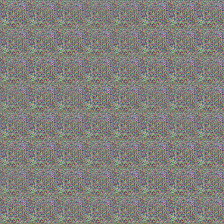

In [ ]:
#display('results/cifar10/WGAN_GP/WGAN_GP_epoch001.png')
from IPython.display import Image
from torchvision.transforms import ToPILImage

display(Image('results/cifar10/GAN/GAN_epoch001.png'))
#display(Image('results/cifar10/WGAN_GP/WGAN_GP_epoch001.png'))

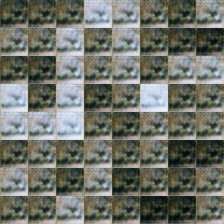

In [ ]:
display(Image('results/cifar10/GAN/GAN_epoch020.png'))
#display(Image('results/cifar10/WGAN_GP/WGAN_GP_epoch050.png'))

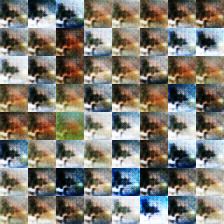

In [ ]:
display(Image('results/cifar10/GAN/GAN_epoch050.png'))
#display(Image('results/cifar10/WGAN_GP/WGAN_GP_epoch050.png'))